In [ ]:
!pip install transformers

In [ ]:
# prob won't need all these but this is just my copy paste
import pandas as pd
import numpy as np
import csv
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F

from tqdm import tqdm, trange, tnrange
import random
import os
import io
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
# check GPU on
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla K80


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
dfmix = pd.read_csv("https://raw.githubusercontent.com/lukasgarbas/nlp-text-emotion/master/data/data_test.csv")
dfmix2 = pd.read_csv("https://raw.githubusercontent.com/lukasgarbas/nlp-text-emotion/master/data/data_train.csv")

In [ ]:
df = pd.concat([dfmix, dfmix2])

In [ ]:
df.head()

,Emotion,Text
0,sadness,I experienced this emotion when my grandfather...
1,neutral,"when I first moved in , I walked everywhere ...."
2,anger,"` Oh ! "" she bleated , her voice high and rath..."
3,fear,"However , does the right hon. Gentleman recogn..."
4,sadness,My boyfriend didn't turn up after promising th...


In [ ]:
df.Emotion.value_counts()

joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: Emotion, dtype: int64

In [ ]:
fairydf = pd.read_csv("/content/drive/MyDrive/datasets/FairyTales/HighValenceFairyTales.csv")

In [ ]:
fairydf = fairydf.drop(['Unnamed: 0'], axis = 1)
fairydf.head()

,Text,Emotion
0,"He looked around on every side and exclaimed, ...",surprise
1,"Then he got up and clambered out of the cave, ...",sad
2,"""Alas, thou canst not help me.""",sad
3,"They leapt nimbly upstairs and downstairs, and...",happy
4,"Then she opened the door of the small house, a...",happy


In [ ]:
fairydf.Emotion.value_counts()

happy       445
sad         264
angry       218
fear        166
surprise    114
Name: Emotion, dtype: int64

In [ ]:
fairydf = fairydf[fairydf.Emotion != 'surprise']

In [ ]:
fairydf.Emotion.value_counts()

happy    445
sad      264
angry    218
fear     166
Name: Emotion, dtype: int64

In [ ]:
df_full = pd.concat([df,fairydf], axis=0)

In [ ]:
df_full.head()

,Emotion,Text
0,sadness,I experienced this emotion when my grandfather...
1,neutral,"when I first moved in , I walked everywhere ...."
2,anger,"` Oh ! "" she bleated , her voice high and rath..."
3,fear,"However , does the right hon. Gentleman recogn..."
4,sadness,My boyfriend didn't turn up after promising th...


In [ ]:
df_full.Emotion.value_counts()

fear       2337
joy        2326
sadness    2317
anger      2259
neutral    2254
happy       445
sad         264
angry       218
Name: Emotion, dtype: int64

In [ ]:
df_full['Emotion'] = df_full['Emotion'].replace('happy', 'joy')
df_full['Emotion'] = df_full['Emotion'].replace('sad', 'sadness')
df_full['Emotion'] = df_full['Emotion'].replace('angry', 'anger')

In [ ]:
df_full.Emotion.value_counts()

joy        2771
sadness    2581
anger      2477
fear       2337
neutral    2254
Name: Emotion, dtype: int64

In [ ]:
labelencoder = LabelEncoder()
df_full['label_enc'] = labelencoder.fit_transform(df_full['Emotion'])
df_full[['Emotion','label_enc']].drop_duplicates(keep='first')

print('Distribution: ', df_full.label_enc.value_counts())

Distribution:  2    2771
4    2581
0    2477
1    2337
3    2254
Name: label_enc, dtype: int64


In [ ]:
labels = df_full.drop_duplicates('Emotion').set_index('label_enc').drop(['Text'],axis=1)
label_dict = labels.to_dict()['Emotion']
label_dict = {value:key for key, value in label_dict.items()}
print(label_dict)

{'sadness': 4, 'neutral': 3, 'anger': 0, 'fear': 1, 'joy': 2}


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_full.Text.values, 
                                                  df_full.label_enc.values, 
                                                  test_size=0.15, 
                                                  random_state=47, 
                                                  stratify=df_full.label_enc.values)

print(X_train[0])
print(X_val[0])

I was driving my car and it was very misty. It was in the night and I was alone in my car. I felt totally insecure, nervous and overstrained.
When I was subjected to a very nasty joke by a group of friends.


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

MAX_LENGTH = 200

# tokenize with bert
                             
encoded_data_train = tokenizer.batch_encode_plus(
    X_train, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=MAX_LENGTH, 
    truncation = True,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    X_val, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=MAX_LENGTH, 
    truncation = True,
    return_tensors='pt'
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train)
print("training size: ", len(input_ids_train))

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_val)
print("val size: ", len(input_ids_val))

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

training size:  10557
val size:  1863


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=5,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
batch_size = 32

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr=2e-5, 
                  eps=1e-8)       
epochs = 5
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [ ]:
# build our evaluation scheme
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        # logits
        '''
        Logits are the unnormalized predictions of the model, we operate on them
        so that they go from raw data to something useful
        '''
        logits = outputs[1]
        loss_val_total += loss.item()
        
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

print(device)

cuda


In [ ]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')


def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
# fine-tuning loop
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, 
                        desc='Epoch {:1d}'.format(epoch), 
                        position = 0, 
                        leave=True, 
                        disable=False)
    
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
    torch.save(model.state_dict(), f'finetuned_BERT_FairyGarbHVCHECK_epoch_{epoch}.model')
        
    print(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    print(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    # get the evaluation info
    print(f'Validation loss: {val_loss}')
    print(f'F1 Score (Weighted): {val_f1}')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':




Epoch 1
Training loss: 0.8720360099817768
Validation loss: 0.5336907293836949
F1 Score (Weighted): 0.820232880993008




Epoch 2
Training loss: 0.4252194542324904
Validation loss: 0.5042727152674885
F1 Score (Weighted): 0.8322577178923535




Epoch 3
Training loss: 0.27298481687903403
Validation loss: 0.5155856532313056
F1 Score (Weighted): 0.8403870219522761




Epoch 4
Training loss: 0.1826902437390703
Validation loss: 0.5575321637472864
F1 Score (Weighted): 0.8360338755193745




Epoch 5
Training loss: 0.13075564001884424
Validation loss: 0.5780967390638286
F1 Score (Weighted): 0.842531688936807



In [ ]:
# load the model and test it
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=5,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('finetuned_BERT_FairyGarbHVCHECK_epoch_4.model', map_location=torch.device('cuda')))

_, predictions, true_vals = evaluate(dataloader_validation)
# check the per-class accuracy
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: anger
Accuracy: 288/372

Class: fear
Accuracy: 305/350

Class: joy
Accuracy: 354/416

Class: neutral
Accuracy: 290/338

Class: sadness
Accuracy: 320/387



In [ ]:
def create_confusion_matrix(preds, labels):
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  y_actu = pd.Series(labels_flat, name='Actual')
  y_pred = pd.Series(preds_flat, name='Predicted')

  df_confusion = pd.crosstab(y_actu, y_pred)
  return df_confusion 

In [ ]:
conf_df = create_confusion_matrix(predictions,true_vals)
print(conf_df)

Predicted    0    1    2    3    4
Actual                            
0          288   18    5   24   37
1           15  305    8    6   16
2            9    5  354   35   13
3           13    7   19  290    9
4           27   21    2   17  320


In [ ]:
import matplotlib.pyplot as plt

def plot_confusion_matrixdf(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

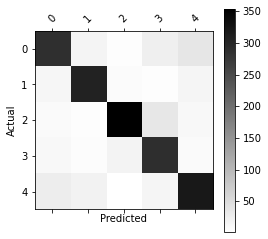

In [ ]:
plot_confusion_matrixdf(create_confusion_matrix(predictions, true_vals))